# <center> RESUME RECOMMENDATION SYSTEM </center>
### <center> Using PSO and Genetic Algorithm </center>

In this project we have created a <b> Resume Recommendation System </b> which parses a directory of resumes and returns the best fit resumes against a job desciption. The entire system can be divided into 3 parts:
<ol>
    <li> <b> Resume and Job Description(JD) Parser </b></li>
    <li> <b> JD and Resume skills extraction using PSO </b></li>
    <li> <b> Resume and JD vectorization and matching using Genetic Algorithm </b>

In [1]:
# Importing necessary files
import streamlit as st
import pandas as pd
import numpy as np
import base64,random
import os
import time,datetime
import PyPDF4
from pyresparser import ResumeParser
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import TextConverter
import io,random
from streamlit_tags import st_tags
from PIL import Image
import PyPDF2
from nltk import *
from spacy.lang.en.stop_words import STOP_WORDS
import string
import itertools

### <center> Part 1: Resume and JD Parser </center>

Part 1 of the project focuses on parsing the resume using the library pdfminer3. This part will parse all the resumes present in the directory and create a dataset of resume information. The job description is also parsed and stored in "job_description".

In [2]:
# Path of files containing the resumes, the JD and the keywords corpus
resume_dir= r"\Uploaded_Resumes"
JD_path= r"\IT Project Manager Job Description.pdf"
skills_path= r"\jd_skills.txt"

# Function to parse a resume file and return text string from the pdf
def read_pdf(file_path):
    with open(file_path, 'rb') as f:
        # Create a PDF reader object
        pdf_reader = PyPDF2.PdfReader(f)
        # Get the number of pages in the PDF file
        num_pages = len(pdf_reader.pages)
        # Iterate over the pages and extract text
        text = ''
        for page_num in range(num_pages):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()
    return text

# Calling the read_pdf function on all the resumes stored in the dir and creating a string list
resume_db=[]
for file in os.listdir(resume_dir):
    file_path= resume_dir + "\\"+ file
    resume_db.append(read_pdf(file_path))


example of a resume parsed into text

In [3]:
print(resume_db[0])

Android Developer
ROBERT SMITHPhone: (123) 456 78 99 
Email: info@qwikresume.com
Website: www.qwikresume.com
LinkedIn:
linkedin.com/qwikresume
Address: 1737 Marshville Road,
Alabama.
Objective
Over 6 years of IT industry experience with 4+ years of experience as Mobile application 
developer in the field of Android. Experience in developing front end applications for Android 
phones. Experience developing mobile applications on Android platform, building Custom UI using 
Views, ViewGroups, Layouts, Widgets and graphics that scale based on the screen size using 9-
patch images, localization, testing and publishing the applications to the Android Market.
Skills
Python, Java, C, Javascript, Matlab, R.
Work Experience
Android Developer
ABC Corporation  ­ January 2011 – March 2012  
Environment Eclipse IDE, Android Studio, GenyMotion, Java, Android SDK, Android 
Development T ools (ADT), JSON, XML,
Involved in the full life cycle of the project including analysis design, development, debu

In [4]:
# Extract skills from Job desciption by matching against skills corpus stored in jd_skills.txt
def JD_extract(pdf_file_path):
    JD= read_pdf(pdf_file_path)
    return JD
job_description= JD_extract(JD_path)
print(job_description)


MICHIGAN CIVIL SERVICE COMMISSION 
 JOB SPECIFICATION 
 INFORMATION TECHNOLOGY PROJECT MANAGER 
Employees in this job function as information technology professionals and are responsible for a variety 
of project, program, and portfolio assignments within a designated Program Management Office (PMO) 
in the Infrastructure Services (IS) Division of the Michigan Department of Technology, Management & 
Budget (MDTMB)or under an Information Officer in Agency Services (AS).  The Program Management 
Office for IS and AS perform Portfolio Management, Program Management, and/or Project Management 
to provide requisite operations and support.

Staff within these designated PMOs provide strategic planning for program and portfolio management, 
aligning skills and resources; monitor, manage, and control agency projects within the designated PMO; 
and provide for all requisite management to fulfill the portfolio/program/project requirements including 
requisitions, releases, and oversight of quali

### <center> Part2: Resume and JD Skill extraction <center>

Skills are extracted from the resume using a modified <b> Particle Swarm Optimization (PSO)</b>. The fitness function is taken as the cosine similarity between the set of skills extracted from the resume and the particle's position.
Keywords are extracted from the JD by matching against a corpus of keywords. Currently we have loaded a corpus of keywords for the IT sector but the same could be expanded for other sectors as well.

In [5]:
# Use particle swarm optimization to extract skills from resume_db and store them in resume_skills
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy


class Particle:
    def __init__(self, dim):
        self.position = np.random.uniform(0, 1, size=dim)
        self.velocity = np.random.uniform(0, 1, size=dim)
        self.best_position = self.position.copy()
        self.fitness = -1  

class PSO:
    def __init__(self, n_particles, dim, max_iter, c1, c2, data):
        self.n_particles = n_particles
        self.dim = dim
        self.max_iter = max_iter
        self.c1 = c1
        self.c2 = c2
        self.particles = [Particle(dim) for i in range(n_particles)]
        self.global_best_position = np.zeros(dim)
        self.global_best_fitness = -1
        self.data = data
        self.vectorizer = CountVectorizer()
        self.skills = self.vectorizer.fit_transform(self.data['resume']).toarray()

    def fitness(self, x):
        # Compute cosine similarity between the set of skills extracted from the resume and the particle's position
        similarity = cosine_similarity(self.skills, x.reshape(1, -1))
        return np.mean(similarity)

    def optimize(self):
        for i in range(self.max_iter):
            for particle in self.particles:
                particle.fitness = self.fitness(particle.position)
                if particle.fitness > particle.best_fitness:
                    particle.best_fitness = particle.fitness
                    particle.best_position = particle.position.copy()
                if particle.fitness > self.global_best_fitness:
                    self.global_best_fitness = particle.fitness
                    self.global_best_position = particle.position.copy()
            for particle in self.particles:
                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                particle.velocity = (particle.velocity
                                     + self.c1 * r1 * (particle.best_position - particle.position)
                                     + self.c2 * r2 * (self.global_best_position - particle.position))
                particle.position = particle.position + particle.velocity

    def extract_skills(resume_text):
        nlp = spacy.load('en_core_web_sm')
        doc = nlp(resume_text)
        skills = []
        # Extract skills
        for token in doc:
            if token.pos_ == 'NOUN':
                for child in token.children:
                    if child.dep_ == 'amod' or child.dep_ == 'compound':
                        skills.append(child.text + ' ' + token.text)
        return set(skills)

# Creating a list of resume skills for all the resumes using PSO class object
resume_skills= []
optimizer= PSO
for i in range(len(resume_db)):
    resume_skills.append(PSO.extract_skills(resume_db[i]))

example of resume skills extracted from a resume

In [ ]:
print(resume_skills[0])

In [6]:
# Extracting keywords from the job description by matching them against a corpus of keywords
# Load pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")
# Tokenize job description and remove stop words and punctuation
tokens = [token for token in word_tokenize(job_description.lower()) if token not in STOP_WORDS and token not in string.punctuation]
# Perform POS tagging on the tokenized text
tagged_tokens = nlp(" ".join(tokens))
with open(skills_path, "r") as f:
    skill_keywords = f.read().splitlines()
# Extract skill phrases from the job description
skill_phrases = []
for chunk in tagged_tokens.noun_chunks:
    if any(keyword in chunk.text for keyword in skill_keywords):
        skill_phrases.append(chunk.text)

# Remove duplicates and sort skill phrases
skill_phrases = list(set(skill_phrases))



Visualizing the JD skills using a word cloud

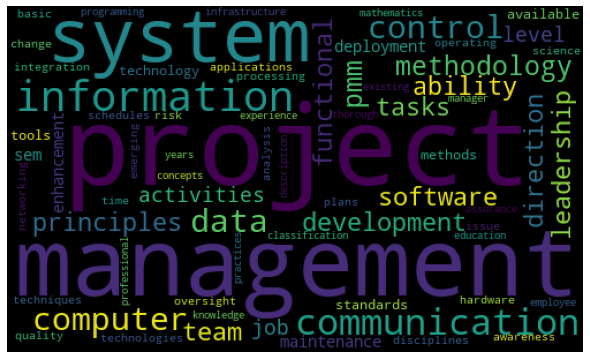

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = " ".join(skill_phrases)
wordcloud = WordCloud(width=500, height=300, background_color='black', stopwords=set()).generate(text)

# Plot the WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### <center> Part 3: Resume and JD vectorization and matching using Genetcic Algorithm </center>

This part of the project works on matching the skills extracted from the resumes and the JD and using a genetic algorithm.
The resume_skills and the skill_phrases (from the JD) are vectorized using count vectorizer and are plotted on an n dimensional vector space.
Each individual of the population is a list of resumes (chromosomes) and the fitness is the sum of cosine similarity of all the resumes in an individual to the JD vector. The fittest individual after a certain number of generations is the group of best fit resumes for the JD

In [8]:
# creating a matrix of vectors for each of the resumes
from sklearn.feature_extraction.text import TfidfVectorizer
# create a list of strings
# create the TF-IDF vectorizer object
vectorizer = TfidfVectorizer()
skill_string = ""
for skill in skill_phrases:
    skill_string= skill_string+ (skill + " ")
# The JD is also inserted at the 0th index as it needs to be vectorized
resume_db.insert(0, skill_string)

# fit the vectorizer object to the text data
vectorizer.fit(resume_db)

# transform the text data into a TF-IDF matrix
tfidf_matrix = vectorizer.transform(resume_db)

# print the TF-IDF matrix
tfidf_matrix= tfidf_matrix.toarray()

In [9]:
# Find the cosine similarities of all the resumes (vectors) with the JD (0th vector)
norm_first_vector = np.linalg.norm(tfidf_matrix[0])
# Compute the dot product of the first vector with all other vectors in the matrix
dot_products = np.dot(tfidf_matrix, tfidf_matrix[0])
# Compute the norms of all vectors in the matrix
norms_matrix = np.linalg.norm(tfidf_matrix, axis=1)
# Compute the cosine similarity of all vectors in the matrix with the first vector
cos_similarities = dot_products / (norm_first_vector * norms_matrix)

# Print the cosine similarities
cos_similarities = [round(num, 4) for num in cos_similarities]

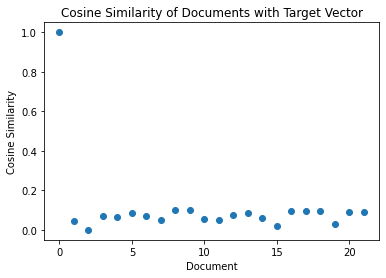

In [10]:
# Create a scatter plot of the cosine similarities
plt.scatter(range(len(cos_similarities)), cos_similarities)
plt.xlabel('Document')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity of Documents with Target Vector')
plt.show()

#### <center> Using genetic algorithm to find the best fit resumes </center>

The fitness of an individual is the sum of cosine similarities of its resumes to the JD. The parents are selected using a roulette wheel selection and crossed at a random crossover point. Any offsprings with duplicate resumes (after mutatation) are removed from the population. The population of the (n+1)th generation is decided by selecting the fittest individuals from the nth generation and the offsprings.

In [11]:
# Definig the parameters of the genetic algorithm
recommendation_size= 5
population_size= 30
generations= 10
mutate_rate= 0.1

# Define the fitness function as the sum of cosine similarities of all resumes(chromosomes) of an individual
def fitness(individual):
    score = 0
    for resume in individual:
        score += cos_similarities[resume]
    return score

# Random population generator for the initial population
def generate_random_numbers(n):
    numbers = list(range(1, len(resume_db)))
    random.shuffle(numbers)
    return numbers[:n]

# Utility function to remove duplicate resumes from and individual
def is_not_permutation_in_list_of_lists(lst, list_of_lists):
    # Generate all permutations of the input list
    permutations = itertools.permutations(lst)
    # Check if any of the permutations exist in the list of lists
    for permutation in permutations:
        if list(permutation) in list_of_lists:
            return False
    return True


# Function to generate initial_population
def generate_init_pop(individual_size, population_size):
    initial_population = []
    while len(initial_population) < population_size:
        individual= generate_random_numbers(individual_size)
        if individual not in initial_population:
            initial_population.append(individual)
    return initial_population
# Mutate function to introduce random variation in an individual.
# Each chromosome of an individual can be replaced by any other chromosome with a random probability
def mutate(child):
    for i in range(len(child)):
        if random.random() < mutate_rate:
            child[i]= random.randint(1,len(resume_db) - 1)
    return child

# Code for the genetic algorithm
def genetic_algo(individual_size, population_size, generations):
    # Generate initial population
    population= generate_init_pop(individual_size, population_size)
    
    
    # Saving average fitness history of each generation for creating a line plot of average fitness vs generation
    fitness_history= []
    # Calculating the fitness score of each individual
    for generation in range(generations):
        curr_fitness_sum= 0
        fitness_scores = [(resume, fitness(resume)) for resume in population]
        
        # Calculating the probability of each individual to be selected as the parent for next generation
        fitness_weight= []
        for i in fitness_scores:
            fitness_weight.append(i[1])
            curr_fitness_sum+= i[1]
        fitness_history.append(curr_fitness_sum/population_size)
        # Creating the offspring generation by crosssover
        offspring = []
        while(len(offspring) < population_size):
            parent1 = random.choices(population, fitness_weight)[0]
            parent2 = random.choices(population, fitness_weight)[0]
            while(parent2== parent1):
                parent2 = random.choices(population, fitness_weight)[0]
            
            # Selecting a random crossover point
            crossover_point = random.randint(0, (individual_size)-1)
            child = parent1[:crossover_point] + parent2[crossover_point:]
            
            # Calling the mutate function on the child
            child = mutate(child)
            if  is_not_permutation_in_list_of_lists(child, offspring+population) and len(set(child))== len(child):
                offspring.append(child)
        
        # Calculating the fitness scores of the individuals of the offspring generation
        offspring_fitness_scores=[(resume, fitness(resume)) for resume in offspring]
        offspring_fitness_scores.sort(key=lambda x: x[1], reverse=True)
        
        # populating the next generation with the fittest individuals from both generations using modified merge sort
        population= []
        i= 0
        j= 0
        while len(population) < population_size:
            if(fitness_scores[i][1] > offspring_fitness_scores[j][1]):
                population.append(fitness_scores[i][0])
                i+= 1
            else:
                population.append(offspring_fitness_scores[j][0])
                j+=1
                
    # Calculating the fitness score for individuals of the last generation            
    fitness_scores = [(resume, fitness(resume)) for resume in population]
    fitness_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Calculating the cosine similarity of the fittest individual
    fittest_individual=[]
    for resume in fitness_scores[0][0]:
        fittest_individual.append((resume, cos_similarities[resume]))
    fittest_individual.sort(key=lambda x: x[1], reverse=True)
    return fittest_individual,fitness_history
    
    
best_resumes, f_history= genetic_algo(recommendation_size, population_size, generations)

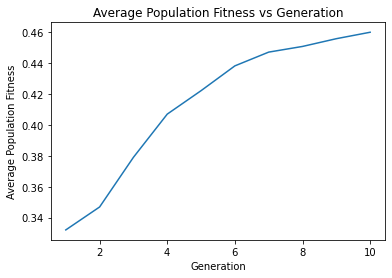

In [12]:
plt.plot(list(range(1,generations+1)),f_history)
# Add labels to the chart
plt.title('Average Population Fitness vs Generation')
plt.ylabel('Average Population Fitness')
plt.xlabel('Generation')

# Display the chart
plt.show()

We can observe that the average fitness value starts to peak after 10 generations

### <center> Final Result </center>
Finally we display the names of the best 5 resumes from the data set.

In [13]:
best_indices= []
for r in best_resumes:
    best_indices.append(r[0] - 1)
resume_files=[]
for file in os.listdir(resume_dir):
    resume_files.append(file)
for i in best_indices:
    print(resume_files[i])

PWC_Wong Zhong Ming_Senior Audit Associate.pdf
PWC_Penny Lim_Risk AM.pdf
Vertex Venture_Ocvia Freriana_Compliance Lead.pdf
UOB AM_Felyna Lee_Product AVP.pdf
Xander_Rohit Khandelwal_VP.pdf
